# Statistical detection of peaks of radio signals
This program takes each event and takes several parts from it:
 * _Selected window_: A window at which is expected that we might have a pulse, taking into account the cable delays from the center of the full window
 * _No selected window_: The rest of the window which was no selected.
 * _Random selected window_: One window randomly located with the same width as the selected window.
 * _Full window_: complete window of the full event

Then, computes for each window the standard deviation, to obtain its distributions.
Then, computes the diference of this parameter between windows, to obtain again their distributions.
Then, computes individual deviations of each sample and computes the deviation for each one.

The histograms are fitted to the more accurate function (normally a gaussian) and events with bin out of the fit are candidates. Then, we search for coincidences of candidate events in the multiple channels.
For the individual deviations, the candidates are the samples beyond a cut, and the candidate events are those with two or more sample candidates. Again, we search for coincidences of events in multiple channels.

The final goal is to find possible peaks according to local variations of a statistical parameter: the *standard deviation*.

###### Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patch
import os
os.chdir('..')
import csv
import scipy.stats as sct
import scipy.optimize as sco
from random import randrange
import microcodes_modules.functions as fc
from microcodes_modules.events import Event
from microcodes_modules.CAENReader import WDReader
from microcodes_modules.CAENReader import readChannels
from microcodes_modules.auto_plots import histo_stats
from collections import Counter

##### List of files of interest (before fixing the voltage problem)
    * prueba_ext_211008_3h
    * waves_211011_0950_5h40
    * waves_211014_0925_2h54
    * waves_211014_1248_1h7
    * waves_211014_1410_2h44
    * waves_211014_2001_6h07
    * waves_211015_1209_0h58
    * waves_211015_1433_7h41
    * waves_211018_1828_2h52
    * waves_211019_0936_21h17
    * waves_211022_1220_69h20

##### List of files of interes (after fixing the voltage problem)
    * waves_211025_1200_27h35

##### List of files of interest (after fixing the voltage problem and decreasing the rate of triggers)
    * wavesh_211028_1302_21h54

###### Settings

In [2]:
### SETTINGS ######################################################################################

###### Settings to read data (options IN)
""" Legend:
        * in_dir -> name of input directory
        * ADC_ch -> number of ADC channels, equal to 2^Nbits
        * nsamp -> number of samples per event
        * deltaT -> real time separation between two samples
        * Vpp -> voltage peak to peak
        * ngroups -> number of groups to study data
        * Nevents -> number of events per group
"""
optin = {   'in_dir':       'wavesh_211105_1146_70h10',
            'ADC_ch':       int(2**14),
            'nsamp':        1030,
            'deltaT':       4,
            'Vpp':          0.5,
            'ngroups':      1,
            'Nevents':      'ind',
            }

cntr_of_fwin = optin['nsamp']/2 # Here is the trigger
# Delays induced by the travel of signals by the cable from antennas to digitizer:
cable_delays = np.array([576.5,574.8,403.0,403.0,286.5,284.7,209.0,207.2]) # ns
# Time of particles from antennas height to floor (where scintillator is)
particle_delay = 30 #ns
# Approximated time of delay of trigger
trigger_delay = 30 #ns
# Total expected pulse delay = cable_delays - particle_delay - trigger_delay
total_delay = cable_delays - particle_delay - trigger_delay
print('Total delay for each channel: ', total_delay, '\n')

win = 100 # width of window in ns. Must be multiple of 4
for i,item in optin.items(): print('%10s: %s' %(i,str(item)))


###### Settings to show and/or save results (options OUT)
optot = {'Show_hists':True,
         'Save_figs': True,
         'Save_stats':True
        }
######

if optot['Save_figs'] or optot['Save_stats']:
    cwd = os.getcwd()
    os.chdir(cwd+'/OUTPUTS')
    list_dir = os.listdir()
    if optin['in_dir'] not in list_dir:
        os.mkdir(optin['in_dir'])
        print(optin['in_dir'],' created in directory OUTPUTS')
    os.chdir(cwd)

Total delay for each channel:  [516.5 514.8 343.  343.  226.5 224.7 149.  147.2] 

    in_dir: wavesh_211105_1146_70h10
    ADC_ch: 16384
     nsamp: 1030
    deltaT: 4
       Vpp: 0.5
   ngroups: 1
   Nevents: ind


In [3]:
READ = readChannels('DATA/'+optin['in_dir'],Vpp=2.0)

file            wave0.dat   size       4086.7 KB
file            wave1.dat   size       4086.7 KB
file            wave2.dat   size       4086.7 KB
file            wave3.dat   size       4086.7 KB
file            wave4.dat   size       4086.7 KB
file            wave5.dat   size       4086.7 KB
file            wave6.dat   size       4086.7 KB
file            wave7.dat   size       4086.7 KB
 Reading file wave0.dat...
  INFO. Reading with header
 Reading file wave1.dat...
  INFO. Reading with header
 Reading file wave2.dat...
  INFO. Reading with header
 Reading file wave3.dat...
  INFO. Reading with header
 Reading file wave4.dat...
  INFO. Reading with header
 Reading file wave5.dat...
  INFO. Reading with header
 Reading file wave6.dat...
  INFO. Reading with header
 Reading file wave7.dat...
  INFO. Reading with header
 Working directory: /home/daniel/Documentos/HYBRID/Antenas


In [4]:
DATA = READ.data()

In [5]:
nevents = READ.nevents()
print('Number of events:', nevents)

Number of events: 1961


In [6]:
file_list = READ.files_list()
print(file_list)

['wave0.dat', 'wave1.dat', 'wave2.dat', 'wave3.dat', 'wave4.dat', 'wave5.dat', 'wave6.dat', 'wave7.dat']


###### Preparing statistics

In [7]:
STATS = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
RNDWI = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}, 5:{}, 6:{}, 7:{}}
DIFFS = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
DESVS = {0:{}, 1:{}, 2:{}, 3:{}, 4:{}, 5:{}, 6:{}, 7:{}}

for wave in file_list:
    ich = int(wave[-5])
    
    ini = int(cntr_of_fwin) + int(total_delay[ich]/optin['deltaT']) #we assume a Hilbert pulse that begins just when the signal arrives to antennas
    fin = ini + win//optin['deltaT']
    print(' Ch ', ich)
    print('Index of start and end of window: ', ini,fin)
    print('Time of start and end of window:  ', ini*optin['deltaT'],fin*optin['deltaT'])
    STATS[ich] = {'sel': [],
                  'nosel': [],
                  'rand': [],
                  'norand': [],
                  'all': []} # statistics of SELected window, NO SELected window and full window (ALL)
    DIFFS[ich] = {'sw-nsw': [],
                  'rw-nrw': [],
                  'sw-rw': []}
    
    for iev,event0 in DATA[ich].items():
        event = event0[1]
        sel_window    = event[ini:fin]
        nosel_window1 = event[:ini]
        nosel_window2 = event[fin+1:]
        nosel_window  = np.concatenate((nosel_window1,nosel_window2))
        
        rand_ini = randrange(optin['nsamp']-win//optin['deltaT'])
        while rand_ini>(ini-win//optin['deltaT']) and rand_ini<fin:
            rand_ini = randrange(optin['nsamp']-win//optin['deltaT'])
        rand_fin = rand_ini + win//optin['deltaT'] # for each event a different window is randomly selected to know if the first selected window behaves differently
        RNDWI[ich][iev] = [rand_ini,rand_fin]
        
        rnd_window    = event[rand_ini:rand_fin]
        nornd_window1 = event[:rand_ini]
        nornd_window2 = event[rand_fin+1:]
        nornd_window  = np.concatenate((nornd_window1,nornd_window2))
        
        mean_all   = np.mean(event)
        std_all    = fc.sqdev(event,mean_all)
        std_sw     = fc.sqdev(sel_window,mean_all)
        std_nsw    = fc.sqdev(nosel_window,mean_all)
        std_rnd    = fc.sqdev(rnd_window,mean_all)
        std_nornd  = fc.sqdev(nornd_window,mean_all)
        
        STATS[ich]['sel'].append(std_sw)
        STATS[ich]['nosel'].append(std_nsw)
        STATS[ich]['rand'].append(std_rnd)
        STATS[ich]['norand'].append(std_nornd)
        STATS[ich]['all'].append(std_all)
        
        DIFFS[ich]['sw-nsw'].append(std_sw-std_nsw)
        DIFFS[ich]['rw-nrw'].append(std_rnd-std_nornd)
        DIFFS[ich]['sw-rw'].append(std_sw-std_rnd)
        
        desv = []
        for sample in sel_window:
            desvi = np.abs(sample-mean_all)/std_all
            desv.append(desvi)
        DESVS[ich][iev] = desv
        
print('\n Data construction is finished')

 Ch  0
Index of start and end of window:  644 669
Time of start and end of window:   2576 2676
 Ch  1
Index of start and end of window:  643 668
Time of start and end of window:   2572 2672
 Ch  2
Index of start and end of window:  600 625
Time of start and end of window:   2400 2500
 Ch  3
Index of start and end of window:  600 625
Time of start and end of window:   2400 2500
 Ch  4
Index of start and end of window:  571 596
Time of start and end of window:   2284 2384
 Ch  5
Index of start and end of window:  571 596
Time of start and end of window:   2284 2384
 Ch  6
Index of start and end of window:  552 577
Time of start and end of window:   2208 2308
 Ch  7
Index of start and end of window:  551 576
Time of start and end of window:   2204 2304

 Data construction is finished


### Comparing two single events

  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
8181.294174757281 3611.866356141413 3576.166634507135


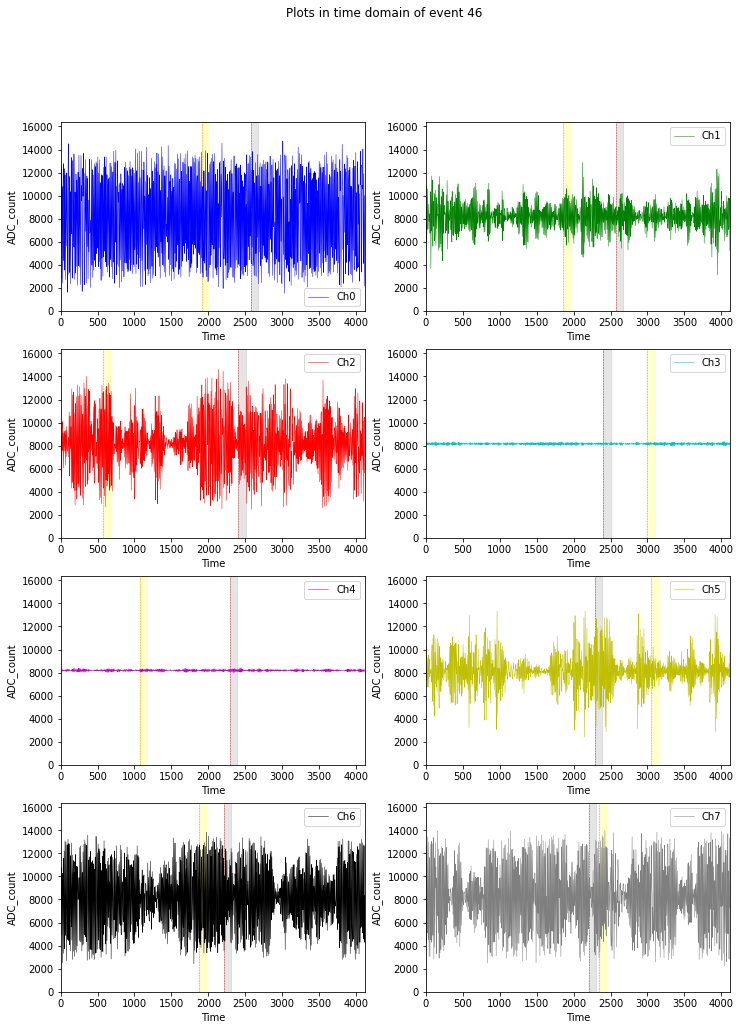

In [8]:
ev = 46

evento = READ.make_events(ev)

ADC_counts_ev = evento[0].ADC_counts()
mean_ev = np.mean(ADC_counts_ev)
sqdv_ev_sel = fc.sqdev(ADC_counts_ev[644:669],mean_ev)
sqdv_ev = fc.sqdev(ADC_counts_ev,mean_ev)
print(mean_ev,sqdv_ev,sqdv_ev_sel)

fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.suptitle('Plots in time domain of event ' + str(ev))
fig.subplots_adjust(hspace=0.2,wspace=0.2)

# Plot:
for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    winini = int(optin['deltaT']*cntr_of_fwin) + total_delay[ich]
    (ax[row][col]).axvline(x=winini,linestyle='--',color='tab:red',linewidth=0.5)
    R = patch.Rectangle((winini,0),win,2**14,color='gray',alpha=0.2)
    (ax[row][col]).add_patch(R)
    
    randini = optin['deltaT']*RNDWI[ich][ev][0]
    randfin = optin['deltaT']*RNDWI[ich][ev][1]
    
    (ax[row][col]).axvline(x=randini,linestyle='--',color='tab:orange',linewidth=0.5)
    Rr = patch.Rectangle((randini,0),win,2**14,color='yellow',alpha=0.2)
    (ax[row][col]).add_patch(Rr)
    
    evento[ich].evn_display(ax[row][col])
    (ax[row][col]).set_xlabel('Time')
    (ax[row][col]).set_ylabel('ADC_count')
    (ax[row][col]).set_xlim(0,4120)
    (ax[row][col]).set_ylim(0,2**14)
    (ax[row][col]).legend()

  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
8178.982524271844 3624.7360152536817 3453.874347273219


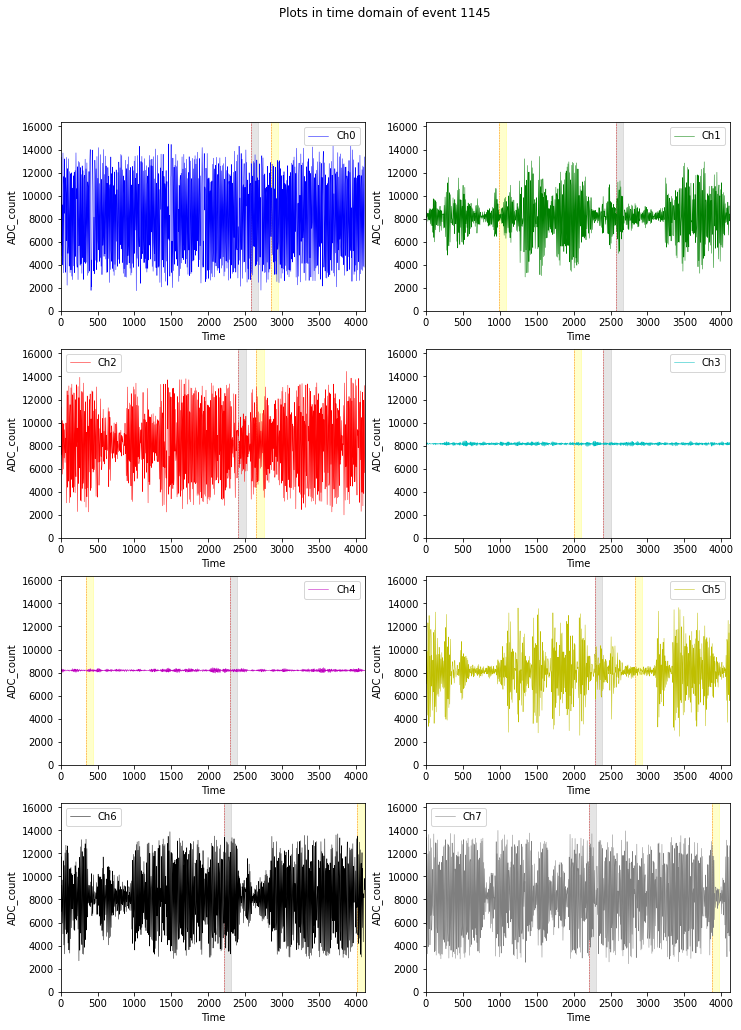

In [9]:
ev = 1145

evento = READ.make_events(ev)

ADC_counts_ev = evento[0].ADC_counts()
mean_ev = np.mean(ADC_counts_ev)
sqdv_ev_sel = fc.sqdev(ADC_counts_ev[644:669],mean_ev)
sqdv_ev = fc.sqdev(ADC_counts_ev,mean_ev)
print(mean_ev,sqdv_ev,sqdv_ev_sel)


# Plot:
fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.suptitle('Plots in time domain of event ' + str(ev))
fig.subplots_adjust(hspace=0.2,wspace=0.2)

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    winini = int(optin['deltaT']*cntr_of_fwin) + total_delay[ich]
    (ax[row][col]).axvline(x=winini,linestyle='--',color='tab:red',linewidth=0.5)
    R = patch.Rectangle((winini,0),win,2**14,color='gray',alpha=0.2)
    (ax[row][col]).add_patch(R)
    
    randini = optin['deltaT']*RNDWI[ich][ev][0]
    randfin = optin['deltaT']*RNDWI[ich][ev][1]
    
    (ax[row][col]).axvline(x=randini,linestyle='--',color='tab:orange',linewidth=0.5)
    Rr = patch.Rectangle((randini,0),win,2**14,color='yellow',alpha=0.2)
    (ax[row][col]).add_patch(Rr)
    
    evento[ich].evn_display(ax[row][col])
    (ax[row][col]).set_xlabel('Time')
    (ax[row][col]).set_ylabel('ADC_count')
    (ax[row][col]).set_xlim(0,4120)
    (ax[row][col]).set_ylim(0,2**14)
    (ax[row][col]).legend()

### Showing one single event

In [10]:
ev = 2

In [11]:
evento = READ.make_events(ev)

  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header
  INFO. Reading with header


In [12]:
ADC_counts_ev = evento[0].ADC_counts()
mean_ev = np.mean(ADC_counts_ev)
sqdv_ev = fc.sqdev(ADC_counts_ev[644:669],mean_ev)
print(mean_ev,sqdv_ev)

8168.738834951457 3687.062049505841


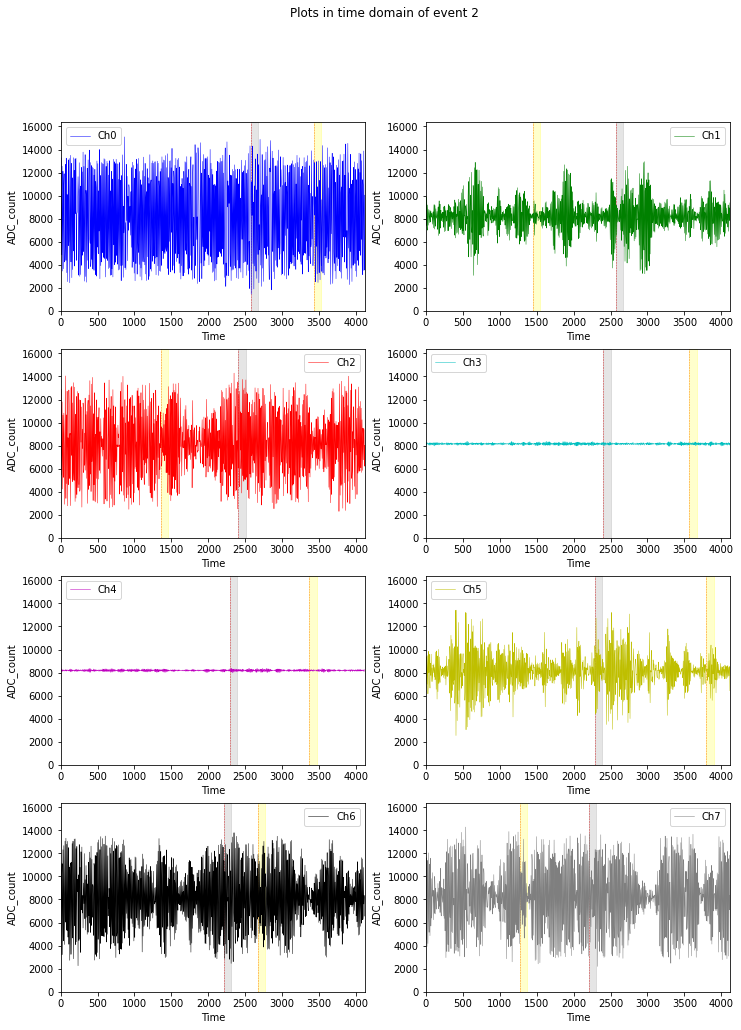

In [13]:
fig, ax = plt.subplots(4,2,figsize=(12,16))
fig.suptitle('Plots in time domain of event ' + str(ev))
fig.subplots_adjust(hspace=0.2,wspace=0.2)

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    winini = int(optin['deltaT']*cntr_of_fwin) + total_delay[ich]
    (ax[row][col]).axvline(x=winini,linestyle='--',color='tab:red',linewidth=0.5)
    R = patch.Rectangle((winini,0),win,2**14,color='gray',alpha=0.2)
    (ax[row][col]).add_patch(R)
    
    randini = optin['deltaT']*RNDWI[ich][ev][0]
    randfin = optin['deltaT']*RNDWI[ich][ev][1]
    
    (ax[row][col]).axvline(x=randini,linestyle='--',color='tab:orange',linewidth=0.5)
    Rr = patch.Rectangle((randini,0),win,2**14,color='yellow',alpha=0.2)
    (ax[row][col]).add_patch(Rr)
    
    evento[ich].evn_display(ax[row][col])
    (ax[row][col]).set_xlabel('Time')
    (ax[row][col]).set_ylabel('ADC_count')
    (ax[row][col]).set_xlim(0,4120)
    (ax[row][col]).set_ylim(0,2**14)
    (ax[row][col]).legend()

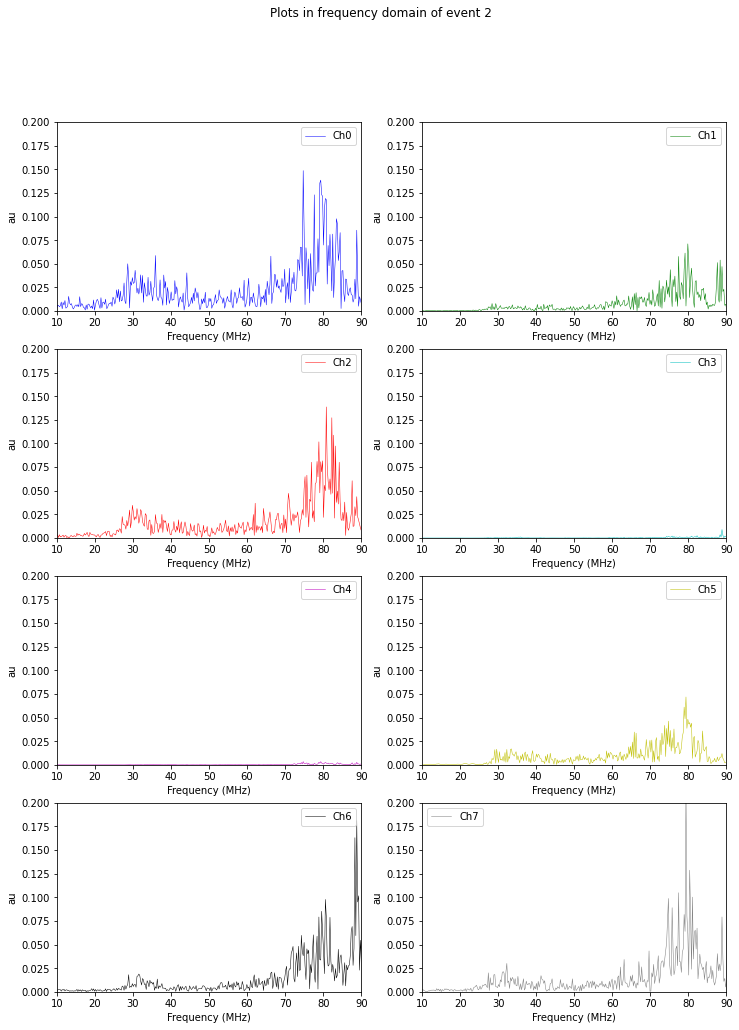

In [14]:
fig0, ax0 = plt.subplots(4,2,figsize=(12,16))
fig0.suptitle('Plots in frequency domain of event ' + str(ev))
fig0.subplots_adjust(hspace=0.2,wspace=0.2)

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    evento[ich].evn_display_fourier(ax0[row][col])
    (ax0[row][col]).set_xlabel('Frequency (MHz)')
    (ax0[row][col]).set_ylabel('au')
    (ax0[row][col]).set_xlim(10,90)
    (ax0[row][col]).set_ylim(0,0.20)
    (ax0[row][col]).legend()

### Statistics of windows

#### Statistics of Standards Deviations

In [15]:
def parabola(x,A,x0,y0):
    return y0 + A*(x-x0)**2

Ch 0
xmin= 3113.0727514602677
xmax= 4146.128674255727
Ch 1
xmin= -492.9350997496198
xmax= 3659.3767634269766
Ch 2
xmin= 65.4224070316694
xmax= 4659.788664880875
Ch 5
xmin= -980.7501402580168
xmax= 4021.379065743142
Ch 6
xmin= 444.1847146718721
xmax= 4750.472683671365
Ch 7
xmin= 221.87064521235752
xmax= 5526.556050791911


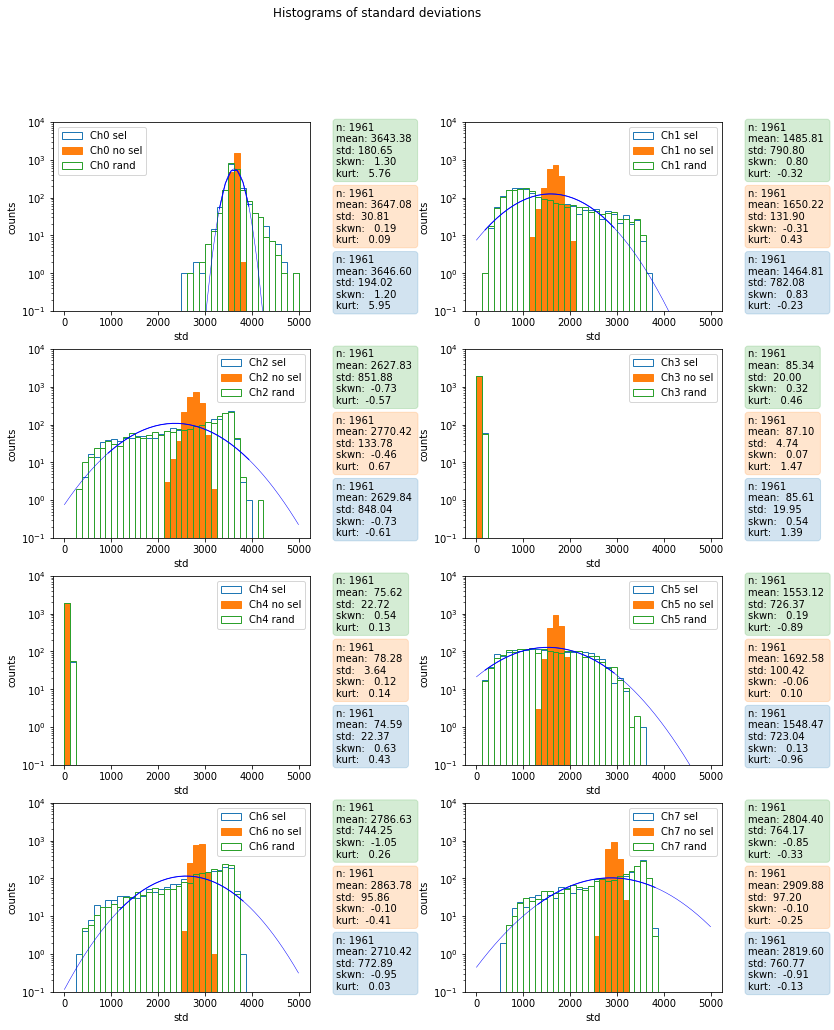

In [18]:
fig2, ax2 = plt.subplots(4,2,figsize=(12,16))
fig2.suptitle('Histograms of standard deviations')
fig2.subplots_adjust(hspace=0.2,wspace=0.6)

candidates = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    lower_limit = 0
    upper_limit = 5000
    plotear = histo_stats((STATS[ich]['sel'],STATS[ich]['nosel'],
                           STATS[ich]['rand']))
    tN, tbines, tpatches = plotear.plot_histo(ax2[row][col],
                       labels=('Ch'+str(ich)+' sel','Ch'+str(ich)+' no sel','Ch'+str(ich)+' rand'),
                       rang = ([lower_limit,upper_limit],[lower_limit,upper_limit],[lower_limit,upper_limit]),
                       bins = (40,40,40),
                       pos_stats=[[1.1,0.15],[1.1,0.5],[1.1,0.85]],
                       log=True,
                       style=(False,True,False),
                       colors=('tab:blue','tab:orange','tab:green'))
    media = plotear.mean()[0]; desvest = plotear.stdev()[0]
    N = tN[0]; bines = tbines[0]; patches = tpatches[0]
    x = []; y=[]
    for i in range(len(N)):
        ctr_of_bin = (bines[i]+bines[i+1])/2
        if N[i]!=0 and np.abs(ctr_of_bin-media)<2*desvest:
            x.append(ctr_of_bin)
            y.append(np.log10(N[i]))
    xp = range(upper_limit)
    if len(x)>3:
        popt, pcov = sco.curve_fit(parabola,x,y)
        A,x0,y0 = popt
        xmin = (2*A*x0 + np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Minimum allowed standard deviation. If less, the event automatically is suspicious to have had a hit
        xmax = (2*A*x0 - np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Maximum allowed standard deviation. If more, the event automatically is suspicious to have had a hit
        print('Ch',ich)
        print('xmin=',xmin)
        print('xmax=',xmax)
        (ax2[row][col]).semilogy(xp,10**(parabola(xp,*popt)),color='b',linewidth=0.5)
        (ax2[row][col]).semilogy(x,10**(parabola(x,*popt)),color='b',linewidth=1.0)
        acc_factor = 1.0 # acceptation factor for width of parabola
        xm = (xmin+xmax)/2
        xmin = xm + acc_factor*(xmin-xm)
        xmax = xm + acc_factor*(xmax-xm)
        #candidates[ich] = []
        for iev,ev_stats in enumerate(STATS[ich]['sel']):
            if ev_stats<xmin or ev_stats>xmax:
                candidates[ich] += [iev,ev_stats]
    (ax2[row][col]).set_xlabel('std')
    (ax2[row][col]).set_ylabel('counts')
    (ax2[row][col]).legend()
    (ax2[row][col]).set_ylim(1e-1,1e4)

In [19]:
for ch,item in candidates.items():
    print(ch,item)

0 [36, 4325.012044238729, 45, 4337.978255215096, 105, 2947.8439027507593, 220, 4266.528057754454, 280, 4290.261974778617, 328, 4236.053594208003, 339, 4228.607193959597, 345, 4221.333009511168, 366, 4148.882261143588, 440, 4284.553805838731, 491, 4236.697218192717, 624, 4942.181087945846, 627, 4227.995739094374, 689, 4333.127723102514, 711, 4409.957389625864, 729, 4396.361573744346, 737, 4214.493163754744, 750, 4342.511374883475, 761, 4541.980229582238, 772, 4505.328644984069, 814, 4342.362722066701, 816, 4331.050428746166, 823, 4234.806893828651, 826, 3055.4281649271775, 854, 4497.840883673179, 858, 4183.045311100239, 862, 3065.295361085616, 885, 4652.221305290902, 926, 2563.5051500132035, 938, 4147.534081465367, 971, 4519.6906870003395, 984, 4319.761504822018, 988, 4237.410083555978, 1050, 2668.1786436876696, 1074, 3041.581923219025, 1123, 4206.177830935839, 1177, 4520.312054616467, 1182, 4234.190564532242, 1194, 3097.790596294392, 1197, 4251.3130283930495, 1220, 4249.416395682781, 1

In [20]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates[chi]) & set(candidates[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S
1 2 :  set()
1 5 :  set()
1 6 :  set()
2 5 :  set()
2 6 :  set()
5 6 :  set()


In [21]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates[chi]) & set(candidates[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  set()
3 7 :  set()
4 7 :  set()


### Statistics of differences between windows

#### Statistics of standard deviations

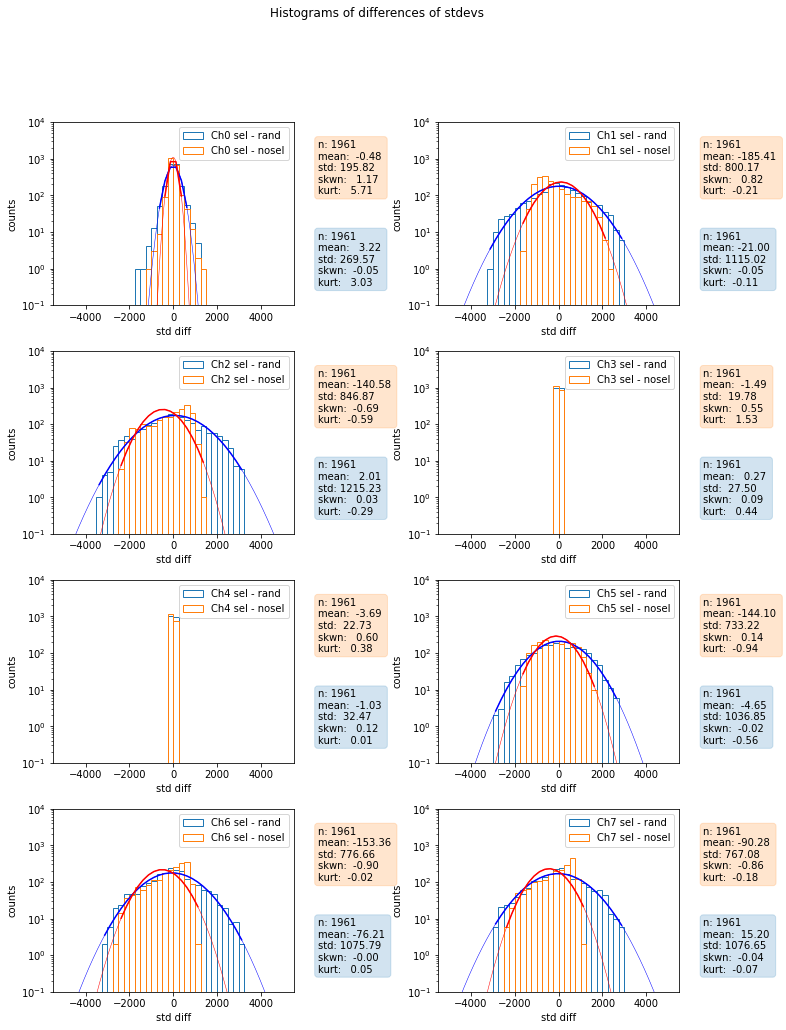

In [23]:
fig5, ax5 = plt.subplots(4,2,figsize=(12,16))
fig5.suptitle('Histograms of differences of stdevs')
fig5.subplots_adjust(hspace=0.25,wspace=0.6,right=0.85)

candidates1 = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]} # candidates given by the difference sel-rand
candidates2 = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]} # candidates given by the difference sel-nosel

lower_limit = -5000
upper_limit = 5000
#std_factors = []

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    plotear = histo_stats((DIFFS[ich]['sw-rw'],DIFFS[ich]['sw-nsw']))
    tN, tbines, tpatches = plotear.plot_histo(ax5[row][col],
                       labels=('Ch'+str(ich)+' sel - rand','Ch'+str(ich)+' sel - nosel'),
                       rang = ([lower_limit,upper_limit],[lower_limit,upper_limit],[lower_limit,upper_limit]),
                       bins = (40,40,40),
                       pos_stats=[[1.1,0.25],[1.1,0.75]],
                       log = True,
                       colors=('tab:blue','tab:orange','tab:green'))
    
    ### FIT AND CANDIDATES FOR DIFFERENCES SELECTED-RANDOM
    media = plotear.mean()[0]; desvest = plotear.stdev()[0]
    N = tN[0]; bines = tbines[0]; patches = tpatches[0]
    x = []; y=[]
    for i in range(len(N)):
        ctr_of_bin = (bines[i]+bines[i+1])/2
        if N[i]!=0 and np.abs(ctr_of_bin-media)<3*desvest:
            x.append(ctr_of_bin)
            y.append(np.log10(N[i]))
    xp = range(lower_limit,upper_limit)
    if len(x)>3:
        popt, pcov = sco.curve_fit(parabola,x,y)
        A,x0,y0 = popt
        (ax5[row][col]).semilogy(xp,10**(parabola(xp,*popt)),'b-',linewidth=0.5)
        (ax5[row][col]).semilogy(x,10**(parabola(x,*popt)),'b-')
        xmin = (2*A*x0 + np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Minimum allowed standard deviation. If less, the event automatically is suspicious to have had a hit
        xmax = (2*A*x0 - np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Maximum allowed standard deviation. If more, the event automatically is suspicious to have had a hit
        #candidates[ich] = []
        for iev,ev_stats in enumerate(DIFFS[ich]['sw-rw']):
            if ev_stats<xmin or ev_stats>xmax:
                candidates1[ich] += [iev,ev_stats]
        
    ### FIT AND CANDIDATES FOR DIFFERENCES SELECTED-NO SELECTED
    media = plotear.mean()[1]; desvest = plotear.stdev()[1]
    N = tN[1]; bines = tbines[1]; patches = tpatches[1]
    x = []; y=[]
    for i in range(len(N)):
        ctr_of_bin = (bines[i]+bines[i+1])/2
        if N[i]!=0 and np.abs(ctr_of_bin-media)<3*desvest:
            x.append(ctr_of_bin)
            y.append(np.log10(N[i]))
    xp = range(lower_limit,upper_limit)
    if len(x)>3:
        popt, pcov = sco.curve_fit(parabola,x,y)
        A,x0,y0 = popt
        (ax5[row][col]).semilogy(xp,10**(parabola(xp,*popt)),'r-',linewidth=0.5)
        (ax5[row][col]).semilogy(x,10**(parabola(x,*popt)),'r-')
        xmin = (2*A*x0 + np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Minimum allowed standard deviation. If less, the event automatically is suspicious to have had a hit
        xmax = (2*A*x0 - np.sqrt(4*A**2*x0**2-4*A*(A*x0**2+y0)))/(2*A) #Maximum allowed standard deviation. If more, the event automatically is suspicious to have had a hit
        #candidates[ich] = []
        for iev,ev_stats in enumerate(DIFFS[ich]['sw-nsw']):
            if ev_stats<xmin or ev_stats>xmax:
                candidates2[ich] += [iev,ev_stats]
    
    (ax5[row][col]).set_xlabel('std diff')
    (ax5[row][col]).set_ylabel('counts')
    (ax5[row][col]).legend()
    (ax5[row][col]).set_ylim(1e-1,1e4)
    
#if optot['Save_figs']: plt.savefig('OUTPUTS/'+optin['in_dir']+'/'+'stds_stats.jpg',dpi=200); print('Figure saved!')

In [24]:
print(candidates1)

{0: [36, 1064.8336441444735, 430, 1047.3627771423812, 602, -1063.3936314265238, 699, -1277.583616860627, 761, 1117.1696168872031, 772, 996.6915316117847, 926, -1598.2280113811053, 1377, -1068.9981675371214, 1398, 1159.515614738485, 1616, -1190.2982832515959, 1619, 1081.1526900718063, 1630, 989.5619040681295, 1836, -1017.6612423459078], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}


In [25]:
print(candidates2)

{0: [36, 710.5062712469467, 45, 739.0113233366128, 105, -714.594871411281, 624, 1313.0609038055477, 689, 693.3748863220117, 711, 699.1434870823164, 729, 762.1649602030911, 750, 738.1921706883109, 761, 867.6258558461172, 772, 869.9100724312257, 814, 703.1534673308133, 816, 662.5217116206068, 854, 797.4058338235736, 885, 1021.2152696404632, 926, -1071.2313633039812, 971, 887.7531994050019, 984, 672.5513760744002, 1050, -964.4011507616706, 1177, 927.2645399471148, 1234, 788.192840340439, 1286, 867.8559057719463, 1373, 646.4741382234465, 1398, 827.4017496325168, 1522, 837.2024535095961, 1609, -805.5653060444897, 1619, 1021.9108363922264, 1630, 906.1049185305237, 1745, 798.7299157106436, 1793, -809.6988411857992, 1817, 669.8896457750657, 1886, -663.667960178565], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: []}


In [26]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-RAND')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates1[chi]) & set(candidates1[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-RAND
1 2 :  set()
1 5 :  set()
1 6 :  set()
2 5 :  set()
2 6 :  set()
5 6 :  set()


In [27]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-RAND')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates1[chi]) & set(candidates1[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-RAND
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  set()
3 7 :  set()
4 7 :  set()


In [28]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-NOSEL')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates2[chi]) & set(candidates2[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. SEL-NOSEL
1 2 :  set()
1 5 :  set()
1 6 :  set()
2 5 :  set()
2 6 :  set()
5 6 :  set()


In [29]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-NOSEL')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates2[chi]) & set(candidates2[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. SEL-NOSEL
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  set()
3 7 :  set()
4 7 :  set()


### Individual deviations

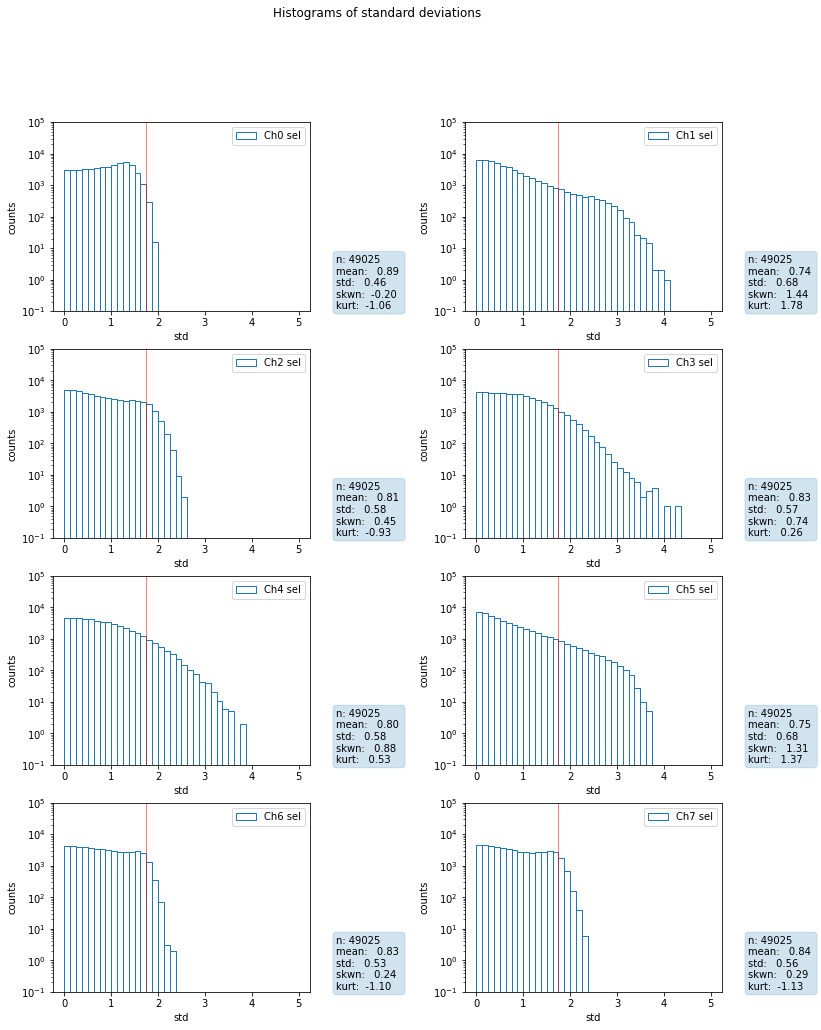

In [31]:
fig7, ax7 = plt.subplots(4,2,figsize=(12,16))
fig7.suptitle('Histograms of standard deviations')
fig7.subplots_adjust(hspace=0.2,wspace=0.6)

candidates3 = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[]}

xmaxs = [2,4,2.5,3.5,4,4,2.5,2.5]
xmaxs = [2,2,2,2,2,2,2,2]
lower_limit = 0
upper_limit = 5

for wave in file_list:
    ich = int(wave[-5])
    row = (ich)//2 ;  col = (ich)%2
    
    desvs = []
    for iev,event in DESVS[ich].items():
        #print(event)
        desvs += event
    plotear = histo_stats((desvs,))
    tN, tbines, tpatches = plotear.plot_histo(ax7[row][col],
                       labels=('Ch'+str(ich)+' sel',),
                       rang = ([lower_limit,upper_limit],[lower_limit,upper_limit],[lower_limit,upper_limit]),
                       bins = (40,),
                       pos_stats=[[1.1,0.15]],
                       log=True,
                       colors=('tab:blue',))
    xmax = np.sqrt(3) # we consider that a sample is suspicious if its deviation from the mean is more than 1/std(square dist.) = sqrt(3)
    (ax7[row][col]).axvline(x=xmax,color='red',linewidth=0.5)
    
    for iev,event in DESVS[ich].items():
        for sample in event:
            if sample>xmaxs[ich]:
                candidates3[ich] += [iev,sample]
    
    (ax7[row][col]).set_xlabel('std')
    (ax7[row][col]).set_ylabel('counts')
    (ax7[row][col]).legend()
    (ax7[row][col]).set_ylim(1e-1,1e5)

In [32]:
print(candidates3)

{0: [], 1: [13, 2.253795940174551, 23, 2.2976549576517242, 23, 2.0887946428923883, 23, 2.075402460784794, 25, 2.449183550310439, 25, 3.2873677761184266, 25, 2.8512215001425547, 27, 2.393601546193219, 27, 3.5614649563286296, 27, 2.2518327471726454, 27, 2.0069549839017715, 27, 2.7171076606976223, 27, 3.077624671039149, 27, 3.127165849696625, 27, 2.8286100960587857, 27, 2.7930180866887873, 27, 3.381266375003808, 27, 2.0849937395936236, 27, 3.142893448526879, 27, 2.4645458695494478, 27, 2.718646394856631, 27, 2.7342541459950014, 28, 4.023145417252445, 28, 2.3006328573807675, 28, 2.242445718306115, 28, 3.745398806736104, 28, 3.448083239932911, 28, 2.7531141283830336, 28, 3.889529668379273, 28, 2.325632613314588, 28, 2.408646265061092, 28, 3.5093736930915447, 28, 2.913710632229074, 28, 3.576870774418141, 28, 3.719796465543257, 28, 2.5706211826871543, 28, 3.0145683399584713, 28, 3.6497986553917054, 28, 3.749104706079112, 31, 2.032736959323916, 31, 3.67759894340611, 31, 3.1593231594330473, 31,

In [33]:
clusters = {}
for ch,lista in candidates3.items():
    cluster = [item for item, count in Counter(lista).items() if count > 1]
    clusters[ch] = cluster
    print(ch,cluster)
    #print(cluster)

0 []
1 [23, 25, 27, 28, 31, 32, 33, 35, 36, 38, 42, 49, 50, 52, 54, 56, 58, 59, 64, 66, 68, 80, 85, 88, 91, 92, 93, 97, 99, 103, 110, 112, 115, 117, 119, 124, 125, 130, 133, 139, 140, 149, 151, 152, 154, 156, 164, 167, 169, 179, 184, 188, 192, 194, 195, 196, 199, 200, 202, 206, 209, 211, 215, 217, 220, 226, 229, 238, 243, 246, 247, 255, 259, 262, 266, 268, 272, 278, 283, 284, 286, 288, 291, 295, 297, 303, 305, 308, 310, 313, 315, 322, 324, 328, 335, 336, 338, 340, 342, 347, 348, 350, 356, 358, 367, 368, 369, 370, 373, 375, 381, 384, 386, 387, 389, 391, 392, 399, 404, 407, 414, 420, 422, 425, 426, 428, 429, 431, 439, 444, 445, 446, 451, 457, 458, 462, 471, 472, 473, 474, 477, 478, 479, 480, 487, 491, 496, 500, 501, 502, 503, 509, 513, 515, 517, 528, 530, 533, 537, 538, 542, 543, 544, 556, 561, 566, 567, 576, 579, 584, 585, 588, 590, 593, 598, 600, 602, 603, 607, 609, 611, 612, 614, 616, 622, 625, 627, 629, 634, 636, 637, 647, 648, 651, 652, 654, 662, 665, 669, 670, 672, 674, 679, 682, 6

In [34]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN PAIRS OF CHANNELS N-S. DESVS')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(clusters[chi]) & set(clusters[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN PAIRS OF CHANNELS N-S. DESVS
1 2 :  {1024, 515, 1156, 902, 1543, 1544, 1927, 1930, 139, 268, 654, 1423, 528, 152, 921, 28, 414, 31, 927, 674, 1699, 1700, 1315, 38, 1062, 1575, 167, 1578, 169, 426, 1838, 52, 1204, 566, 1207, 64, 1477, 839, 584, 1097, 1608, 712, 1356, 206, 1486, 1234, 340, 1239, 729, 1883, 92, 348, 477, 990, 1888, 737, 1249, 1635, 1001, 1900, 110, 1135, 369, 370, 1393, 1398, 503, 255}
1 5 :  {1543, 1033, 1554, 1047, 25, 1049, 27, 28, 1563, 542, 1056, 33, 1569, 38, 1065, 42, 1535, 556, 1578, 1071, 49, 52, 566, 56, 58, 1082, 1594, 1598, 64, 576, 1601, 1605, 1095, 584, 1096, 1608, 590, 80, 593, 1109, 1623, 600, 1626, 1115, 1629, 1632, 97, 609, 99, 1123, 614, 1646, 1135, 625, 1143, 634, 125, 1149, 1663, 1156, 133, 1670, 647, 648, 1671, 139, 140, 651, 1679, 1683, 152, 1176, 1689, 1185, 164, 1700, 167, 169, 1709, 1198, 1200, 689, 690, 179, 1201, 1204, 694, 1207, 696, 1713, 1718, 188, 701, 1215, 192, 194, 1730, 196, 173

In [35]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(clusters[chi]) & set(clusters[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  {1031, 1034, 1549, 1049, 1050, 27, 34, 1065, 1578, 1082, 1601, 1097, 586, 1615, 1126, 103, 1639, 620, 113, 1148, 1152, 130, 650, 140, 1676, 1685, 1181, 159, 1185, 676, 1199, 1713, 1717, 1727, 1728, 1732, 1734, 724, 1751, 233, 1259, 1262, 1277, 1293, 270, 273, 790, 1311, 1829, 808, 1320, 316, 847, 1361, 1875, 1878, 1367, 345, 1374, 1888, 1891, 1395, 884, 1397, 1403, 391, 1935, 408, 1433, 413, 1445, 423, 942, 1454, 434, 447, 451, 970, 1487, 1503, 1508, 1002, 1003, 1525}
3 7 :  {256, 385, 290, 676, 69, 456, 759, 463, 177, 761, 1751, 729}
4 7 :  {676, 870, 1384, 617, 1067, 908, 1107, 118, 1751, 572}


In [36]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS N-S. DESVS')
rest_of_ch = [1,2,5,6]
print('1 2 5: ', set(clusters[1]) & set(clusters[2]) & set(clusters[5]))
print('1 2 6: ', set(clusters[1]) & set(clusters[2]) & set(clusters[6]))
print('2 5 6: ', set(clusters[1]) & set(clusters[2]) & set(clusters[6]))
print('1 2 5 6: ', set(clusters[1]) & set(clusters[2]) & set(clusters[5]) & set(clusters[6]))

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS N-S. DESVS
1 2 5:  {1156, 902, 1927, 1543, 1930, 139, 268, 1423, 152, 921, 28, 414, 927, 1700, 38, 167, 169, 1578, 52, 1204, 566, 1207, 64, 584, 1608, 712, 1234, 340, 1239, 1883, 348, 477, 737, 1249, 1900, 1135, 369, 370, 503, 255}
1 2 6:  {1234, 990}
2 5 6:  {1234, 990}
1 2 5 6:  {1234}


In [37]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS E-W. DESVS')
rest_of_ch = [0,3,4,7]
print('0 3 4: ', set(clusters[0]) & set(clusters[3]) & set(clusters[4]))
print('0 3 7: ', set(clusters[0]) & set(clusters[3]) & set(clusters[7]))
print('3 4 7: ', set(clusters[3]) & set(clusters[4]) & set(clusters[7]))
print('0 3 4 7: ', set(clusters[0]) & set(clusters[3]) & set(clusters[4]) & set(clusters[7]))

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES OF CLUSTERS IN GROUPS>2 OF CHANNELS E-W. DESVS
0 3 4:  set()
0 3 7:  set()
3 4 7:  {676, 1751}
0 3 4 7:  set()


In [38]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. DESVS')
rest_of_ch = [1,2,5,6]
for chi in [1,2,5,6]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates3[chi]) & set(candidates3[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS N-S. DESVS
1 2 :  {1024, 513, 515, 1029, 1031, 1543, 1544, 528, 23, 25, 1563, 28, 1053, 1564, 31, 543, 35, 1061, 38, 1062, 1575, 42, 1578, 556, 1580, 52, 566, 56, 1082, 1597, 64, 577, 1089, 68, 1604, 1607, 584, 1097, 1608, 1100, 592, 593, 1616, 85, 600, 1113, 603, 92, 1115, 1630, 607, 97, 609, 1634, 1635, 614, 110, 1135, 112, 1649, 119, 1148, 126, 640, 1665, 130, 643, 1156, 647, 1160, 1674, 139, 1676, 654, 149, 152, 665, 154, 1689, 1696, 1185, 674, 1699, 1700, 167, 1703, 169, 1709, 176, 1204, 1207, 696, 701, 1215, 1730, 709, 1734, 199, 712, 1225, 206, 1743, 1234, 1749, 1239, 729, 1241, 1243, 220, 1757, 737, 226, 1249, 1254, 1766, 232, 744, 1769, 238, 755, 1780, 246, 765, 255, 259, 268, 780, 1293, 1295, 272, 1296, 1301, 1818, 1311, 288, 1826, 291, 804, 805, 1315, 1318, 1838, 303, 308, 1848, 313, 825, 315, 1852, 1857, 839, 1866, 1867, 1356, 1357, 1872, 338, 340, 857, 1882, 1883, 348, 1886, 863, 1888, 356, 869, 1383, 1900, 3

In [39]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS')
rest_of_ch = [0,3,4,7]
for chi in [0,3,4,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates3[chi]) & set(candidates3[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF CHANNELS E-W. DESVS
0 3 :  set()
0 4 :  set()
0 7 :  set()
3 4 :  {2, 514, 1027, 1540, 1031, 520, 1544, 1034, 1549, 528, 1044, 1046, 23, 25, 1049, 27, 1050, 1567, 1569, 34, 1058, 1571, 1062, 40, 552, 1065, 1578, 1580, 1581, 1070, 1071, 48, 562, 51, 563, 1074, 1076, 1587, 1591, 569, 1082, 1594, 572, 1084, 62, 1597, 1601, 66, 1090, 584, 1097, 74, 586, 1100, 77, 589, 1101, 1613, 1615, 1618, 84, 1110, 1628, 96, 1634, 100, 612, 102, 103, 1126, 1637, 1639, 620, 1132, 624, 113, 1648, 627, 1140, 118, 120, 1148, 1152, 130, 1666, 1667, 1670, 137, 650, 651, 140, 1163, 1676, 1168, 1171, 660, 1685, 664, 153, 1176, 1690, 1181, 1693, 159, 1185, 163, 676, 1705, 170, 1197, 1199, 689, 1713, 180, 181, 694, 1717, 696, 185, 186, 698, 701, 1213, 1725, 192, 193, 1727, 1728, 1732, 1734, 1223, 200, 204, 1742, 1234, 1235, 724, 215, 1751, 1752, 1757, 1760, 226, 1766, 233, 1259, 1260, 1262, 242, 755, 250, 1277, 256, 257, 1794, 773, 1287, 264, 1293, 270, 273,

In [40]:
print('SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF ALL CHANNELS. DESVS')
rest_of_ch = [0,1,2,3,4,5,6,7]
for chi in [0,1,2,3,4,5,6,7]:
    del rest_of_ch[0]
    for chj in rest_of_ch:
        possible = set(candidates3[chi]) & set(candidates3[chj])
        print(chi,chj,': ',possible)

SETS OF POSSIBLE CANDIDATES BY COINCIDENCES IN PAIRS OF ALL CHANNELS. DESVS
0 1 :  set()
0 2 :  set()
0 3 :  set()
0 4 :  set()
0 5 :  set()
0 6 :  set()
0 7 :  set()
1 2 :  {1024, 513, 515, 1029, 1031, 1543, 1544, 528, 23, 25, 1563, 28, 1053, 1564, 31, 543, 35, 1061, 38, 1062, 1575, 42, 1578, 556, 1580, 52, 566, 56, 1082, 1597, 64, 577, 1089, 68, 1604, 1607, 584, 1097, 1608, 1100, 592, 593, 1616, 85, 600, 1113, 603, 92, 1115, 1630, 607, 97, 609, 1634, 1635, 614, 110, 1135, 112, 1649, 119, 1148, 126, 640, 1665, 130, 643, 1156, 647, 1160, 1674, 139, 1676, 654, 149, 152, 665, 154, 1689, 1696, 1185, 674, 1699, 1700, 167, 1703, 169, 1709, 176, 1204, 1207, 696, 701, 1215, 1730, 709, 1734, 199, 712, 1225, 206, 1743, 1234, 1749, 1239, 729, 1241, 1243, 220, 1757, 737, 226, 1249, 1254, 1766, 232, 744, 1769, 238, 755, 1780, 246, 765, 255, 259, 268, 780, 1293, 1295, 272, 1296, 1301, 1818, 1311, 288, 1826, 291, 804, 805, 1315, 1318, 1838, 303, 308, 1848, 313, 825, 315, 1852, 1857, 839, 1866, 1867,